In [29]:
import s3fs
import fsspec
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import io
import skimage
from PIL import Image
import scipy
from cellpose import utils, models
import glob

In [65]:
def get_stain_img (protein):
    # get path to stain
    s3 = s3fs.S3FileSystem(anon=True)
    protein_path = [x for x in s3.ls(f"s3://czb-opencell/microscopy/raw/") if protein in x][0]
    print(protein_path)
    s3r = boto3.resource("s3", config=Config(signature_version=UNSIGNED))
    imgs = []
    print(s3.ls(protein_path))
    for f in s3.ls(protein_path):
        if "stack" in f:
            print(f)
            bucket = s3r.Bucket('czb-opencell',)
            obj = bucket.Object(f.lstrip("czb-opencell/"))
            img_data = obj.get().get('Body').read()
            img = Image.open(io.BytesIO(img_data),mode='r',formats=["TIFF"])
            imgs.append(img)
            # TEMP
            break
    return imgs

def tiff_to_array (img):
    # stain
    c0 = []
    # nucleus stain
    c1 = []
    for i in range(img.n_frames):
        print(i)
        img.seek(i)
        if i % 2 == 0:
            c0.append(np.array(img))
        else:
            c1.append(np.array(img))
    return np.array([c0,c1])

def get_cellpose_masks (array_img, diameter=90, cellprob_threshold=0.4):
    model = models.Cellpose(gpu=False, model_type='cyto')
    masks, flows, styles, diams = model.eval(array_img, do_3D=True, diameter=diameter, cellprob_threshold=cellprob_threshold, channels=[0,None])
    return masks

In [69]:
subunit = "POLR2F"
subunit_imgs = get_stain_img(subunit)
array_img = tiff_to_array(subunit_imgs[0])
masks = get_cellpose_masks(array_img)

czb-opencell/microscopy/raw/POLR2F_ENSG00000100142
['czb-opencell/microscopy/raw/POLR2F_ENSG00000100142/OC-FOV_POLR2F_ENSG00000100142_CID000701_FID00025277_proj.tif', 'czb-opencell/microscopy/raw/POLR2F_ENSG00000100142/OC-FOV_POLR2F_ENSG00000100142_CID000701_FID00025277_stack.tif', 'czb-opencell/microscopy/raw/POLR2F_ENSG00000100142/OC-FOV_POLR2F_ENSG00000100142_CID000701_FID00028538_proj.tif', 'czb-opencell/microscopy/raw/POLR2F_ENSG00000100142/OC-FOV_POLR2F_ENSG00000100142_CID000701_FID00028538_stack.tif', 'czb-opencell/microscopy/raw/POLR2F_ENSG00000100142/OC-FOV_POLR2F_ENSG00000100142_CID000701_FID00028539_proj.tif', 'czb-opencell/microscopy/raw/POLR2F_ENSG00000100142/OC-FOV_POLR2F_ENSG00000100142_CID000701_FID00028539_stack.tif', 'czb-opencell/microscopy/raw/POLR2F_ENSG00000100142/OC-FOV_POLR2F_ENSG00000100142_CID000701_FID00028540_proj.tif', 'czb-opencell/microscopy/raw/POLR2F_ENSG00000100142/OC-FOV_POLR2F_ENSG00000100142_CID000701_FID00028540_stack.tif', 'czb-opencell/microscopy

# generalized fn

In [70]:
#cell_labels = np.unique(masks)
def cut_to_label_bounds (masks, label, array_img):
    c_mask = np.where(np.array(masks)==label)
    bounds_0 = min(c_mask[0]), max(c_mask[0])
    bounds_1 = min(c_mask[1]), max(c_mask[1])
    bounds_2 = min(c_mask[2]), max(c_mask[2])

    cell_stack_mask = np.array(masks[:])
    cell_stack_mask[np.where(masks!=label)] = 0
    
    cell_stack_mask = cell_stack_mask[bounds_0[0]:bounds_0[1],bounds_1[0]:bounds_1[1],bounds_2[0]:bounds_2[1]]
    cell_stack_c0 = array_img[0][bounds_0[0]:bounds_0[1],bounds_1[0]:bounds_1[1],bounds_2[0]:bounds_2[1]]
    cell_stack_c1 = array_img[1][bounds_0[0]:bounds_0[1],bounds_1[0]:bounds_1[1],bounds_2[0]:bounds_2[1]]
    return cell_stack_mask, cell_stack_c0, cell_stack_c1

def correlate_by_frame (array_img, masks, fn, norm=False, flatten = False, mip=False, mip_axis = None, per_frame=True):
    cell_labels = np.unique(masks)
    print(cell_labels)
    # per_frame_corrs = []
    results = [] 
    for c in cell_labels:
        if c == 0:
            continue
        c_corrs = []
        cell_stack_mask, cell_stack_c0, cell_stack_c1 = cut_to_label_bounds(masks, c, array_img)
      
        # if per cell and MIP
        # TODO mask !
        if not per_frame and (mip and mip_axis is not None):
            print("MIP unsupported")
            return
            mip_c0 = np.max(cell_stack_c0, axis=mip_axis)
            mip_c1 = np.max(cell_stack_c1, axis=mip_axis)
            if norm: 
                mip_c0 = mip_c0/np.linalg.norm(mip_c0)
                mip_c1 = mip_c0/np.linalg.norm(mip_c1)
            if flatten:
                mip_c0 = np.ravel(mip_c0)
                mip_c1 = np.ravel(mip_c1)
            res = fn(mip_c0, mip_c1)
            results.append(res)
            continue
        
        # if per frame and/or not MIP
        c0_allframes = []
        c1_allframes = []
        c_frames_res = []
        for i in range(np.shape(cell_stack_mask)[0]):
            # Note: we mutate c0_slice and c1_slice directly.
            c0_slice = cell_stack_c0[i]
            c1_slice = cell_stack_c1[i]
            mask_slice = cell_stack_mask[i]
            mask_pixels = np.where(mask_slice!=0)
            if not all([x >= 2 for x in np.shape(mask_pixels)]):
                continue
            c0_slice = c0_slice[mask_pixels]
            c1_slice = c1_slice[mask_pixels]
            
            # todo consider hstacking
            if not per_frame:
                c0_allframes = c0_allframes + list(np.ravel(c0_slice))
                c1_allframes = c1_allframes + list(np.ravel(c1_slice))
                continue
            if norm: 
                c0_slice = c0_slice/np.linalg.norm(c0_slice)
                c1_slice = c1_slice/np.linalg.norm(c1_slice)
            if flatten:
                c0_slice = np.ravel(c0_slice)
                c1_slice = np.ravel(c1_slice)
            
            res = fn(c0_slice,c1_slice) 
            c_frames_res.append(res)
        
        if per_frame:
            results.append(c_frames_res)

        if not per_frame and flatten:
            if norm:
                c0_allframes = c0_allframes/np.linalg.norm(c0_allframes)
                c1_allframes = c1_allframes/np.linalg.norm(c1_allframes)
            res = fn(c0_allframes,c1_allframes)
            results.append(res)
    return results

In [73]:
xcorrs = correlate_by_frame(array_img, masks, lambda a, b : np.mean(scipy.signal.correlate(a,b, mode="full")), norm=True, flatten = True, mip=False, per_frame = True)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]


<Axes: ylabel='Density'>

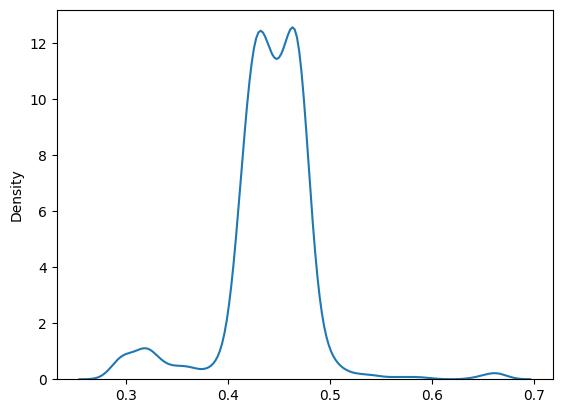

In [74]:
sns.kdeplot(np.hstack([np.hstack(x) for x in xcorrs]))